## Exploración de series de tiempo de la evolución de distintas criptomonedas

Es preciso mencionar que mi conocimiento sobre las criptomonedas en estas instancias es basicamente nulo, sin embargo, creo que esto me puede dar una perspectiva objetiva en el análisis de los resultados que se obtengan. Mi plan es hacer una investigación posterior, la cual contraste los análisis hechos en esta exploración con el panorama real de las criptomonedas. 

En el curso se han visto distintas técnicas, y sería realmente complicado abordar todas ellas. 

Aquí he seleccionado algunas que me parece podrían aportar información que nos permita dilucidar la relación que existe entre las distintas criptomonedas. 

### 0.- Apertura de datos

In [1]:
from binance.client import Client
from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
#Importamos las clases que hicimos en tareas pasadas 
from CorrelationCalculator import CorrelationCalculator
from DistributionComparator import DistributionComparator
import warnings
warnings.filterwarnings('ignore')
import DataQuantizer
import DimReductor
from FeatureCalculator import FeatureCalculator
from random import randrange

In [6]:
class CoinType(str,Enum):
    BITCOIN = "BTC"
    ETHEREUM = "ETH"
    BNB = "BNB"
    CARDANO = "ADA"
    DOGECOIN = "DOGE"
    RIPPLE = "XRP"
    POLKADOT = "DOT"
    LITECOIN = "LTC"
    SOLANA = "SOL"
    BITCOIN_CASH = "BCH"
    CHAINLINK = "LINK"
    POLYGON = "MATIC"
    THETA = "THETA"
    STELLAR = "XLM"
    VECHAIN = "VET"
    ETHER_CLASSIC = "ETC"
    FILECOIN = "FIL"
    TRON = "TRX"
    BAT = "BAT"
    QTUM = "QTUM"
    WAZIRX = "WRX"
    
class CryptoInfoRetriever:
    #Las fechas deben estar en formato estandar UTC "YYYY-MM-DD"
    def __init__(self, initialDate, finalDate):
        self.apiKey = "HbrskJyT2YwAbKqSKO6lwe9QO1pZzza4pB5eyDpaWFwkRSts6QNXQZ1gROgCzmgw"
        self.secretKey = "Y1K1BnyPRvtDnHq3shDALkl2SMwlhZu2ZxG6rdJmOo82ZPvSh5kT5amWbW7hCoMS"
        
        #Inicializamos el cliente
        self.interval = "1h"
        self.client = Client(self.apiKey, self.secretKey)
        self.initialDate = initialDate
        self.finalDate = finalDate
    
    #Ya esta, ahora podemos acceder a las series de tiempo que necesitemos
    
    def retrieveMonthlyData(self, coinType):
        d = self.client.get_historical_klines(coinType.value+"USDT", self.interval,self.initialDate, self.finalDate, limit = 500)
        n = len(d)
        #El precio de la criptomoneda está en la segunda posición
        prices = []
        for i in range(0,n):
            ohlcv = d[i]
            prices.append(ohlcv[1])
        prices = np.array([float(x) for x in prices])
        prices = (prices - np.mean(prices))/np.std(prices)
        return np.arange(0,n, 1), prices
    
    
    def getAllCoinSeriesDictionary(self):
        seriesDictionary = {}
        for coin in CoinType:
            tArr, timeSeries = self.retrieveMonthlyData(coin)
            seriesDictionary[coin] = timeSeries
        
        return tArr, seriesDictionary
        
    
    

Text(0, 0.5, 'Precio (USDT)')

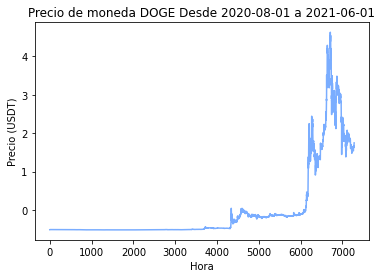

In [20]:
#Prueba funcionamiento de la apertura de datos
cType = CoinType.DOGECOIN
cryptoRetriever = CryptoInfoRetriever("2020-08-01", "2021-06-01")
hoursArray, resultingTimeSeries = cryptoRetriever.retrieveMonthlyData(cType)

plt.figure()
plt.plot(hoursArray, resultingTimeSeries, color = "#7aadff")
plt.title("Precio de moneda "+cType.value + " Desde "+cryptoRetriever.initialDate+ " a "+cryptoRetriever.finalDate)
plt.xlabel("Hora")
plt.ylabel("Precio (USDT)")


ValueError: x and y must have same first dimension, but have shapes (7285,) and (6854,)

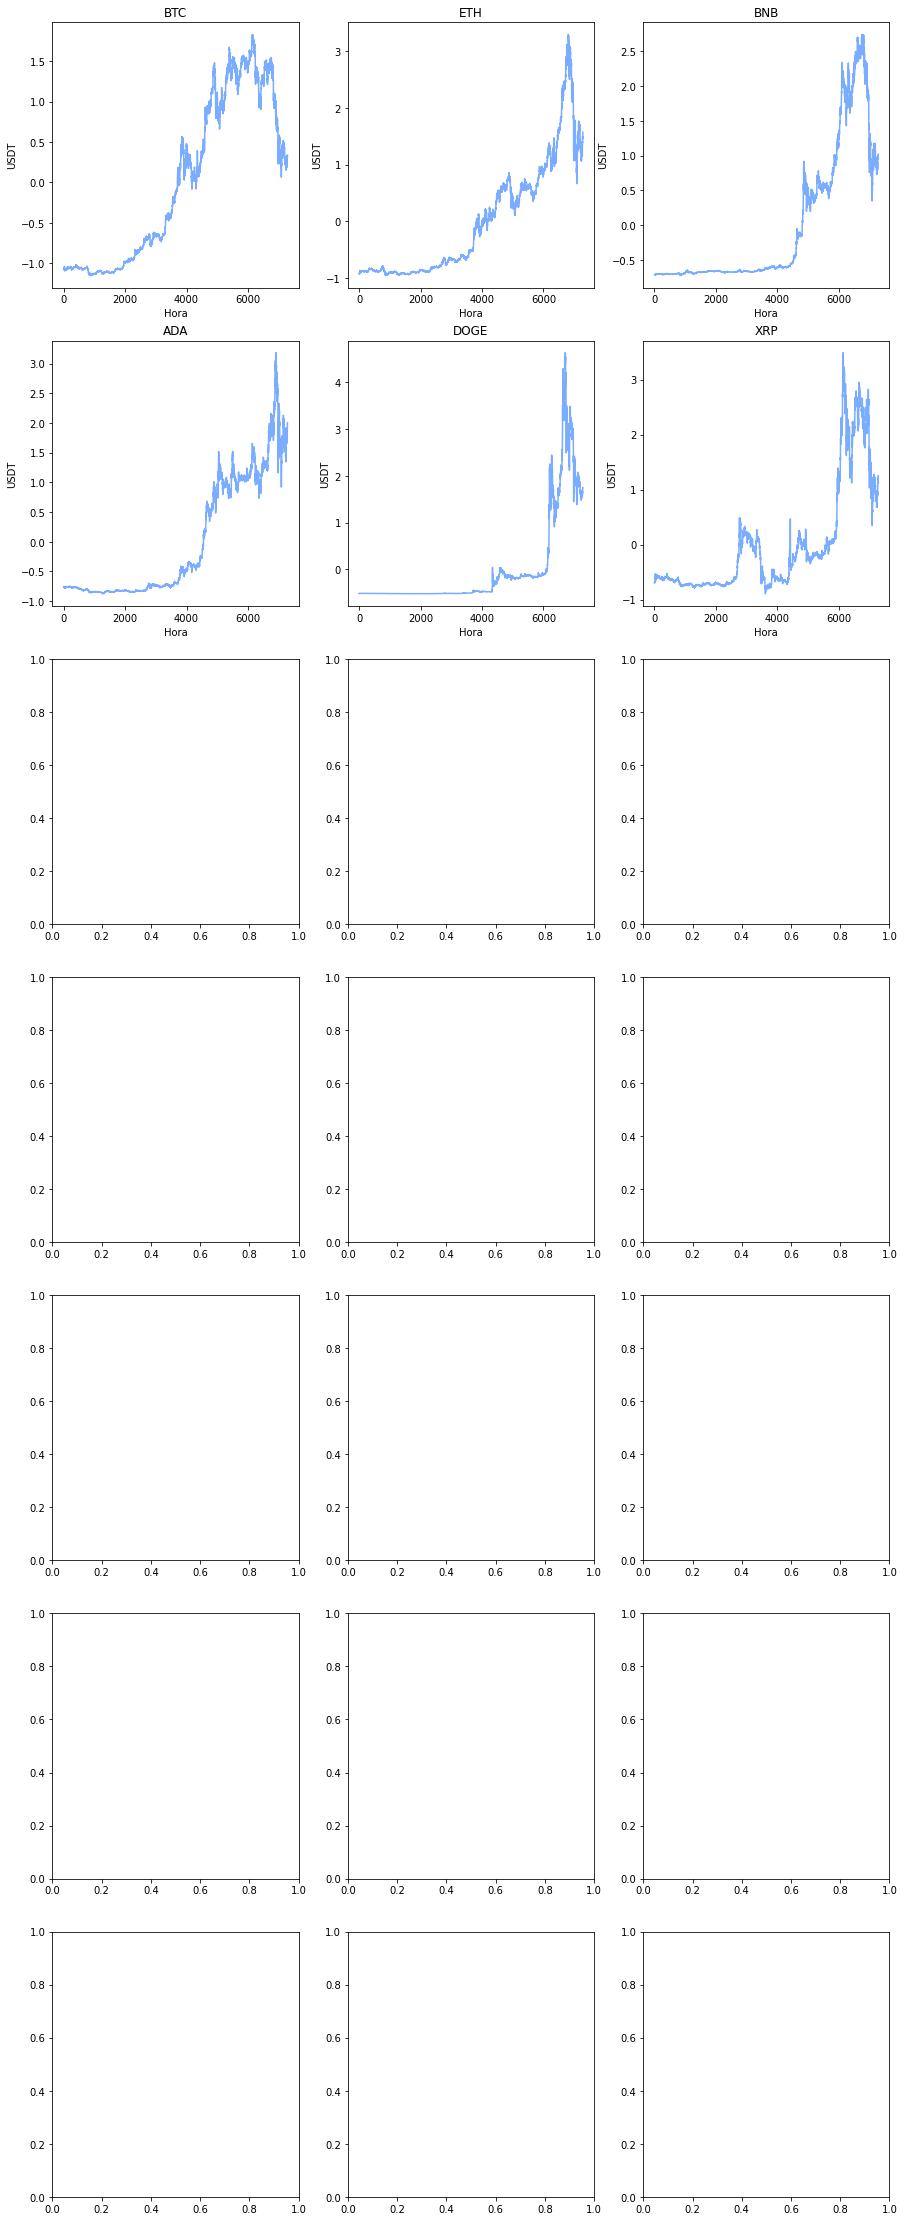

In [21]:
#Visualicemos todas las series de tiempo
tArr, seriesDictionary = cryptoRetriever.getAllCoinSeriesDictionary()
n = len(CoinType)
rows = int(np.floor(n/3))
if(n % 3 >0):
    rows = rows + 1 
fig, ax = plt.subplots(rows, 3, figsize = (15, 40))
counter = 0
for coin in CoinType:
    row = int(counter/3)
    col = counter%3
    ax[row, col].plot(tArr, seriesDictionary[coin], color = "#7aadff")
    ax[row, col].set_title(coin.value)
    ax[row, col].set_xlabel("Hora")
    ax[row, col].set_ylabel("USDT")
    counter = counter + 1

### 1.- Dependencias entre variables

#### 1.1.- Coeficiente de correlación de pearson

In [ ]:
#Creamos el calculador de correlaciones
corrCalculator = CorrelationCalculator()
coinTypes = [c for c in CoinType]
coinNames = [c.value for c in coinTypes]

n = len(coinTypes)
correlationTable = np.zeros((n,n))
significanceTable = np.zeros((n,n))
tolerance = 0.01
maxCorrelation = float('-Inf')
maxCorrelationIndex1 = 0
maxCorrelationIndex2 = 0
minCorrelation = float('Inf')
minCorrelationIndex1 = 0
minCorrelationIndex2 = 0



for i in range(0,n):
    cType1 = coinTypes[i]
    timeSeries1 = seriesDictionary[cType1]
    for j in range(0,n): 
        cType2 = coinTypes[j]
        timeSeries2 = seriesDictionary[cType2]
        corr, pValue = corrCalculator.getPearsonCorrelation(timeSeries1, timeSeries2)
        correlationTable[i,j]  = np.abs(corr)
        
        if(i != j and np.abs(corr) >= maxCorrelation):
            maxCorrelation = corr
            maxCorrelationIndex1 = i
            maxCorrelationIndex2 = j
        
        if(i != j and np.abs(corr) <= minCorrelation):
            minCorrelation = np.abs(corr)
            minCorrelationIndex1 = i
            minCorrelationIndex2 = j

        if(pValue < tolerance):
            significanceTable[i,j] = 1

for i in range(0,n):
    for j in range(0,n):
        if(correlationTable[i,j] == maxCorrelation):
            print("max: "+coinNames[i] + "->"+coinNames[j])
for i in range(0,n):
    for j in range(0,n):
        if(correlationTable[i,j] == minCorrelation):
            print("min: "+coinNames[i] + "->"+coinNames[j])
#Imprimimos entre que criptomonedas se encontraron las menores correlaciones
print("La menor correlación de Pearson se encontró entre "+str(coinNames[minCorrelationIndex1]) + " y "+str(coinNames[minCorrelationIndex2]))
print("La mayor correlación de Pearson se encontró entre "+str(coinNames[maxCorrelationIndex1]) + " y "+str(coinNames[maxCorrelationIndex2]))

fig, ax = plt.subplots(1,2, figsize = (30, 10))
color1 = ax[0].pcolormesh(correlationTable, cmap = 'plasma')
ax[0].set_title("Pares de correlaciones de Pearson")
ax[0].set_xticklabels(coinNames)
ax[0].set_yticklabels(coinNames)
ax[0].set_xticks(range(1,len(coinNames)+1));
ax[0].set_yticks(range(1,len(coinNames)+1));
fig.colorbar(color1, ax = ax[0])
color2 = ax[1].pcolormesh(significanceTable, cmap = 'plasma')
ax[1].set_title("Pruebas de hipótesis Pearson")
ax[1].set_xticklabels(coinNames)
ax[1].set_yticklabels(coinNames)
ax[1].set_xticks(range(1,len(coinNames)+1));
ax[1].set_yticks(range(1,len(coinNames)+1));
fig.colorbar(color2, ax = ax[1])

        

#### 1.2. Información mutua

In [ ]:
corrCalculator = CorrelationCalculator()
coinTypes = [c for c in CoinType]
coinNames = [c.value for c in coinTypes]

n = len(coinTypes)
mutualInformationTable = np.zeros((n,n))

minMIIndex1 = 0
minMIIndex2 = 0
minMI = float('Inf')
maxMIIndex1 = 0
maxMIIndex2 = 0
maxMI = float('-Inf')


for i in range(0,n):
    cType1 = coinTypes[i]
    timeSeries1 = seriesDictionary[cType1]
    for j in range(0,n):
        cType2 = coinTypes[j]
        timeSeries2 = seriesDictionary[cType2]
        mutualInformation = corrCalculator.getMutualInformation(timeSeries1, timeSeries2)
        mutualInformationTable[i,j] = mutualInformation
        
        if(i != j and mutualInformation >= maxMI):
            maxMI = mutualInformation
            maxMIIndex1 = i
            maxMIIndex2 = j
        
        if(i != j and  mutualInformation <= minMI):
            minMI = mutualInformation
            minMIIndex1 = i
            minMIIndex2 = j
print("La menor información mutua se encontró entre "+str(coinNames[minMIIndex1]) + " y "+str(coinNames[minMIIndex2]))
print("La mayor información mutua se encontró entre "+str(coinNames[maxMIIndex1]) + " y "+str(coinNames[maxMIIndex2]))

fig, ax = plt.subplots(figsize = (15,8))
color = ax.pcolormesh(mutualInformationTable,cmap = 'plasma')
ax.set_title("Pares de Informaciones Mutuas")
ax.set_xticklabels(coinNames)
ax.set_yticklabels(coinNames)
ax.set_xticks(range(1,len(coinNames)+1));
ax.set_yticks(range(1,len(coinNames)+1));
fig.colorbar(color, ax = ax)


### 2. Comparación de distribuciones

#### 2.1.- Distancia Euclideana

In [ ]:
distComparator = DistributionComparator()
tArr, seriesDictionary = cryptoRetriever.getAllCoinSeriesDictionary()
n = len(CoinType)
rows = int(np.floor(n/3))
if(n % 3 >0):
    rows = rows + 1 
fig, ax = plt.subplots(rows, 3, figsize = (15, 40))
counter = 0
for coin in CoinType:
    row = int(counter/3)
    col = counter%3
    normData = (seriesDictionary[coin] - np.mean(seriesDictionary[coin]))/np.std(seriesDictionary[coin])
    vals, dist = distComparator.getDistribution(normData)
    print(len(vals))
    print(len(dist))
    ax[row, col].bar(vals, dist, color = "#7aadff")
    ax[row, col].set_title(coin.value)
    counter = counter + 1

In [ ]:
coinTypes = [c for c in CoinType]
coinNames = [c.value for c in coinTypes]

n = len(coinTypes)
distanceTable = np.zeros((n,n))

minEuclideanIndex1 = 0
minEuclideanIndex2 = 0
minEuclidean = float('Inf')
maxEuclideanIndex1= 0
maxEuclideanIndex2 = 0
maxEuclidean = float('-Inf')


for i in range(0,n):
    cType1 = coinTypes[i]
    timeSeries1 = seriesDictionary[cType1]
    for j in range(0,n):
        cType2 = coinTypes[j]
        timeSeries2 = seriesDictionary[cType2]
        distance = distComparator.getEuclideanDistance(timeSeries1, timeSeries2)
        distanceTable[i,j] = distance
        
        if(i != j and distance >= maxEuclidean):
            maxEuclidean = distance
            maxEuclideanIndex1 = i
            maxEuclideanIndex2 = j
        
        if(i != j and  distance <= minEuclidean):
            minEuclidean = distance
            minEuclideanIndex1 = i
            minEuclideanIndex2 = j
print("La menor distancia euclidiana se encontró entre "+str(coinNames[minEuclideanIndex1]) + " y "+str(coinNames[minEuclideanIndex2]))
print("La mayor distancia euclidiana se encontró entre "+str(coinNames[maxEuclideanIndex1]) + " y "+str(coinNames[maxEuclideanIndex2]))

fig, ax = plt.subplots(figsize = (15,8))
color = ax.pcolormesh(distanceTable,cmap = 'plasma')
ax.set_title("Pares de distancias euclidianas entre distribuciones")
ax.set_xticklabels(coinNames)
ax.set_yticklabels(coinNames)
ax.set_xticks(range(1,len(coinNames)+1));
ax.set_yticks(range(1,len(coinNames)+1));
fig.colorbar(color, ax = ax)


#### 2.2.- Distancia Normal

In [ ]:
distComparator = DistributionComparator()
coinTypes = [c for c in CoinType]
coinNames = [c.value for c in coinTypes]

n = len(coinTypes)
distanceTable = np.zeros((n,n))

minNormalIndex1 = 0
minNormalIndex2 = 0
minNormal = float('Inf')
maxNormalIndex1= 0
maxNormalIndex2 = 0
maxNormal = float('-Inf')


for i in range(0,n):
    cType1 = coinTypes[i]
    timeSeries1 = seriesDictionary[cType1]
    for j in range(0,n):
        cType2 = coinTypes[j]
        timeSeries2 = seriesDictionary[cType2]
        distance = distComparator.getNormalDistance(timeSeries1, timeSeries2)
        distanceTable[i,j] = distance
        
        if(i != j and distance >= maxNormal):
            maxNormal = distance
            maxNormalIndex1 = i
            maxNormalIndex2 = j
        
        if(i != j and  distance <= minNormal):
            minNormal = distance
            minNormalIndex1 = i
            minNormalIndex2 = j
            
print("La menor distancia normal se encontró entre "+str(coinNames[minNormalIndex1]) + " y "+str(coinNames[minNormalIndex2]))
print("La mayor distancia normal se encontró entre "+str(coinNames[maxNormalIndex1]) + " y "+str(coinNames[maxNormalIndex2]))

fig, ax = plt.subplots(figsize = (15,8))
color = ax.pcolormesh(distanceTable,cmap = 'plasma')
ax.set_title("Pares de distancias normales entre distribuciones")
ax.set_xticklabels(coinNames)
ax.set_yticklabels(coinNames)
ax.set_xticks(range(1,len(coinNames)+1));
ax.set_yticks(range(1,len(coinNames)+1));
fig.colorbar(color, ax = ax)


#### 2.3. Wasserstein Distance

In [ ]:
distComparator = DistributionComparator()
coinTypes = [c for c in CoinType]
coinNames = [c.value for c in coinTypes]

n = len(coinTypes)
distanceTable = np.zeros((n,n))

minWassersteinIndex1 = 0
minWassersteinIndex2 = 0
minWasserstein = float('Inf')
maxWassersteinIndex1= 0
maxWassersteinIndex2 = 0
maxWasserstein = float('-Inf')


for i in range(0,n):
    cType1 = coinTypes[i]
    timeSeries1 = seriesDictionary[cType1]
    for j in range(0,n):
        cType2 = coinTypes[j]
        timeSeries2 = seriesDictionary[cType2]
        distance = distComparator.computeWassersteinDistance(timeSeries1, timeSeries2)
        distanceTable[i,j] = distance
        
        if(i != j and distance > maxWasserstein):
            maxWasserstein = distance
            maxWassersteinIndex1 = i
            maxWassersteinIndex2 = j
        
        if(i != j and  distance < minWasserstein):
            minWasserstein = distance
            minWassersteinIndex1 = i
            minWassersteinIndex2 = j
print("La menor distancia Wasserstein se encontró entre "+str(coinNames[minWassersteinIndex1]) + " y "+str(coinNames[minWassersteinIndex2]))
print("La mayor distancia Wasserstein se encontró entre "+str(coinNames[maxWassersteinIndex1]) + " y "+str(coinNames[maxWassersteinIndex2]))

fig, ax = plt.subplots(figsize = (15,8))
color = ax.pcolormesh(distanceTable,cmap = 'plasma')
ax.set_title("Pares de distancias  Wasserstein entre distribuciones")
ax.set_xticklabels(coinNames)
ax.set_yticklabels(coinNames)
ax.set_xticks(range(1,len(coinNames)+1));
ax.set_yticks(range(1,len(coinNames)+1));
fig.colorbar(color, ax = ax)


#### 2.4. Prueba de Kolmogorov

In [ ]:
distComparator = DistributionComparator()
coinTypes = [c for c in CoinType]
coinNames = [c.value for c in coinTypes]
tolerance = 0.01
n = len(coinTypes)
distanceTable = np.zeros((n,n))

for i in range(0,n):
    cType1 = coinTypes[i]
    timeSeries1 = seriesDictionary[cType1]
    for j in range(0,n):
        cType2 = coinTypes[j]
        timeSeries2 = seriesDictionary[cType2]
        pValue = distComparator.kolmogorovTest(timeSeries1, timeSeries2)
        distanceTable[i,j] = distance
        
        if(pValue < tolerance):
            distanceTable[i,j] = 1

fig, ax = plt.subplots(figsize = (15,8))
color = ax.pcolormesh(distanceTable,cmap = 'plasma')
ax.set_title("Pruebas de Kolmogorov")
ax.set_xticklabels(coinNames)
ax.set_yticklabels(coinNames)
ax.set_xticks(range(1,len(coinNames)+1));
ax.set_yticks(range(1,len(coinNames)+1));
fig.colorbar(color, ax = ax)

### 3. Reducción de dimensionalidad

In [ ]:
#Primero vamos a calcular todas las características
coinTypes = [c for c in CoinType]
coinNames = [c.value for c in coinTypes]
featureCalculator = FeatureCalculator()
nFeatures = featureCalculator.getNumberOfFeatures()
nCoins = len(coinTypes)
X = np.zeros((nCoins, nFeatures))

for i in range(0, len(coinTypes)):
    ct = coinTypes[i]
    timeSeries = seriesDictionary[ct]
    tArr = np.arange(0,len(timeSeries),1)
    featuresVector = featureCalculator.computeAllFeatureVector(timeSeries, tArr)
    X[i,:] = featuresVector
    

In [ ]:
#Ahora examinemos el efecto de los distintos métodos de reducción de la dimensinalidad que vimos
dimReductor = DimReductor.DimReductor()
pcaReduced = dimReductor.PCAReduction(X, 2)
tsneReduced = dimReductor.tSNEReduction(X, 2)
isomapReduced = dimReductor.isomapReduction(X, 2)
#Para la reducción SOM necesitamos mas parámetros
neuronWidth = 3
neuronHeight = 3
radius = 3
learningRate = 0.9
epochs = 1000

uMatrix, winners = dimReductor.SOMReduction(X, neuronHeight, neuronWidth, radius, learningRate,  epochs)

fig, ax = plt.subplots(1, 5, figsize = (20, 5))
ax[0].plot(pcaReduced[:,0], pcaReduced[:,1], color = "#7aadff", marker = 'o', linestyle = 'none')
ax[0].set_title("PCA")
ax[0].set_xlabel("Componente 1")
ax[0].set_ylabel("Componente 2")
for i in range(0,np.size(pcaReduced, 0)):
    ax[0].text(pcaReduced[i,0], pcaReduced[i,1], coinNames[i])
ax[1].plot(tsneReduced[:,0], tsneReduced[:,1], color = "#7aadff", marker = 'o', linestyle = 'none')
ax[1].set_title("tSNE")
ax[1].set_xlabel("y")
ax[1].set_ylabel("x")
for i in range(0,np.size(tsneReduced, 0)):
    ax[1].text(tsneReduced[i,0], tsneReduced[i,1], coinNames[i])
ax[2].plot(isomapReduced[:,0], isomapReduced[:,1],color = "#7aadff", marker = 'o', linestyle = 'none')
ax[2].set_title("ISOMAP")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
for i in range(0,np.size(isomapReduced, 0)):
    ax[2].text(isomapReduced[i,0], isomapReduced[i,1], coinNames[i])
ax[3].pcolormesh(uMatrix, cmap = "plasma")
ax[3].set_title("U-Matrix")
ax[3].set_xlabel("x")
ax[3].set_ylabel("y")
ax[4].plot([a[0] for a in winners],[a[1] for a in winners], color = "#7aadff", marker = 'o', linestyle = 'none')
ax[4].set_title("SOM")
ax[4].set_xlabel("x")
ax[4].set_ylabel("y")
for i in range(0,len(winners)):
    ax[4].text(winners[i][0], winners[i][1], coinNames[i])

### 4. Cuantización de vectores

In [ ]:
def getRandomColor():
    s = "#"
    r = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
    g = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
    b = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
    s = s+r+g+b
        
    return s


In [ ]:
k = 5
vecQuantizer = DataQuantizer.DataQuantizer()
centroidColor  = getRandomColor()
classColors = [getRandomColor() for i in range(0,k)]

cKMeans, lkMeans = vecQuantizer.applyKMeans(k, pcaReduced)
ckMedians, lkMeadians = vecQuantizer.applyKMedians(k, pcaReduced)
cSOM, lSOM = vecQuantizer.applySOM(pcaReduced, 3, 1, 3, 0.9, 1000)
cAP, lAP = vecQuantizer.applyAffinityPropagation(pcaReduced)

fig, ax = plt.subplots(1, 4, figsize = (20, 5))
#ax[0].plot(cKMeans[:,0], cKMeans[:,1], color = centroidColor, marker = 'o', linestyle = 'none')
for i in range(0, len(lkMeans)):
    label = int(lkMeans[i])
    print(label)
    ax[0].plot(pcaReduced[i,0], pcaReduced[i,1], color = classColors[label], marker = 'o', linestyle = 'none')
    ax[0].text(pcaReduced[i,0], pcaReduced[i,1], coinNames[i])
ax[0].set_title("kMeans")
#ax[1].plot(ckMedians[:,0], ckMedians[:,1], color = centroidColor,marker = 'o', linestyle = 'none')
for i in range(0, len(lkMeans)):
    label = int(lkMeadians[i])
    ax[1].plot(pcaReduced[i,0], pcaReduced[i,1], color = classColors[label], marker = 'o', linestyle = 'none')
    ax[1].text(pcaReduced[i,0], pcaReduced[i,1], coinNames[i])
ax[1].set_title("kMedians")
#ax[2].plot(cSOM[0][:,0], cSOM[0][:,1], color = centroidColor,marker = 'o', linestyle = 'none')
for i in range(0, len(lSOM)):
    label = int(lSOM[i][1])
    ax[2].plot(pcaReduced[i,0], pcaReduced[i,1], color = classColors[label], marker = 'o', linestyle = 'none')
    ax[2].text(pcaReduced[i,0], pcaReduced[i,1], coinNames[i])
ax[2].set_title("SOM")
#ax[3].plot(cAP[:,0], cAP[:,1], color = centroidColor,marker = 'o', linestyle = 'none')
colorsAP = [getRandomColor() for i in range(0,len(np.unique(lAP)))]
for i in range(0, len(lAP)):
    label = int(lAP[i])
    ax[3].plot(pcaReduced[i,0], pcaReduced[i,1], color = colorsAP[label], marker = 'o', linestyle = 'none')
    ax[3].text(pcaReduced[i,0], pcaReduced[i,1], coinNames[i])
ax[3].set_title("AP")

In [16]:
plt.imshow(som.getUMatrix())

NameError: name 'som' is not defined

In [ ]:
np.arange(1,100,2)

In [ ]:
len(seriesDictionary[CoinType.DOGECOIN])